# Phase transition

This notebook illustrates the phase transition for perfect recovery.

Observations:

- it's the SBM generation that takes the most time, not so much the inference.
  Keeping 10 iterations of cavi is fine.
- `delta_inf` works best close to $(K - 1) / K$.
  I set it at 0.799

In [1]:
import collabclass
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
n = 1000
k = 5
s = 5
alpha = 0.5
deltas = np.array([0.03, 0.1, 0.2])

ms = np.linspace(100, 20000, num=10, dtype=int)
n_draws = 100

In [3]:
%%time
np.random.seed(0)

samples = np.zeros((len(ms), n_draws), dtype=object)
for i, m in enumerate(ms):
    for j in range(n_draws):
        # Tuple `(us, vs, graph)`.
        samples[i, j] = collabclass.sbm(m=m, n=n, k=k, s=s, alpha=alpha)

CPU times: user 16min 45s, sys: 9.53 s, total: 16min 55s
Wall time: 16min 56s


In [4]:
def experiment(predict):
    res = np.zeros((len(deltas), len(ms), 2*n_draws))
    for z, delta in enumerate(deltas):
        for i, m in enumerate(ms):
            print(".", end="", flush=True)
            for j in range(n_draws):
                us, vs, graph = samples[i, j]
                for o in range(2):
                    vs_hat = collabclass.symmetric_channel(vs, k, delta)
                    # Run the predictor.
                    vs_bar = predict(graph, vs_hat)
                    # Evaluate accuracy.
                    #fraction_connected = np.count_nonzero(graph.item_idx[:,1] > 0) / n
                    res[z, i, 2*j + o] = np.count_nonzero(vs_bar == vs) / n
    print()
    return res

### CAVI

In [5]:
%%time
np.random.seed(0)

delta_inf = 0.799

def cavi(graph, vs_hat):
    alpha_prior = alpha * np.ones((len(graph.user_idx), k))
    beta_prior = collabclass.init_beta(k, vs_hat, delta_inf)
    _, beta = collabclass.cavi(graph, alpha_prior, beta_prior, n_iters=10)
    return np.argmax(beta, axis=1)

res = experiment(cavi)

..............................
CPU times: user 13min 1s, sys: 2.47 s, total: 13min 3s
Wall time: 13min 6s


### wvRN

In [6]:
%%time
np.random.seed(0)
res2 = experiment(collabclass.wvrn)

..............................
CPU times: user 29.2 s, sys: 164 ms, total: 29.3 s
Wall time: 29.5 s


### Plot data

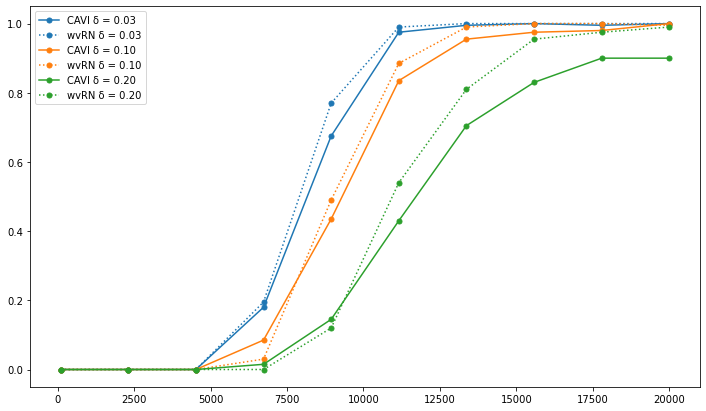

In [7]:
fig, ax = plt.subplots(figsize=(12, 7))

for z, delta in enumerate(deltas):
    cavi = np.mean(res[z] == 1, axis=1)
    wvrn = np.mean(res2[z] == 1, axis=1)
    ax.plot(ms, cavi, marker="o", ms=5, color=plt.cm.tab10(z),
            label=f"CAVI δ = {delta:.2f}")
    ax.plot(ms, wvrn, marker="o", ms=5, color=plt.cm.tab10(z), linestyle=":",
            label=f"wvRN δ = {delta:.2f}")

ax.legend()